# Imports and configs

In [1]:
!uv pip install -q --system autogluon scikit-learn==1.5.2

In [2]:
from autogluon.tabular import TabularPredictor
from autogluon.core.metrics import make_scorer
from sklearn.model_selection import KFold
from scipy.stats import pearsonr as pr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import os

warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/drw-crypto-market-prediction/train.parquet"
    test_path = "/kaggle/input/drw-crypto-market-prediction/test.parquet"
    sample_sub_path = "/kaggle/input/drw-crypto-market-prediction/sample_submission.csv"
    
    target = "label"
    n_folds = 5
    seed = 42
    time_limit = 3600 * 11

# Loading data and predefining folds

In [4]:
train = pd.read_parquet(CFG.train_path).reset_index(drop=True)
test = pd.read_parquet(CFG.test_path).reset_index(drop=True)

In [5]:
features = [
    # https://www.kaggle.com/code/sadettinamilverdil/yat-r-m-tavsiyesi-de-ildir
    "X863", "X856", "X344", "X598", "X862", "X385", "X852", "X603", "X860", "X674",
    "X415", "X345", "X137", "X855", "X174", "X302", "X178", "X532", "X168", "X612",
    "bid_qty", "ask_qty", "buy_qty", "sell_qty", "volume"
]

train = train[features + [CFG.target]]
test = test[features]

In [6]:
kf = KFold(n_splits=CFG.n_folds, shuffle=False)
split = kf.split(train, train[CFG.target])
for i, (_, val_index) in enumerate(split):
    train.loc[val_index, "fold"] = i

# Fitting the predictor

In [7]:
%%writefile custom_metric.py

from autogluon.core.metrics import make_scorer
from scipy.stats import pearsonr as pr

def pearsonr(y_true, y_pred):
    return pr(y_true, y_pred)[0]

ag_pearsonr = make_scorer(
    name='pearsonr',
    score_func=pearsonr,
    optimum=1,
    greater_is_better=True
)

Writing custom_metric.py


In [8]:
from custom_metric import ag_pearsonr

predictor = TabularPredictor(
    path="/logs",
    problem_type="regression",
    eval_metric=ag_pearsonr,
    label=CFG.target,
    groups="fold",
    verbosity=2
)

In [9]:
predictor.fit(
    train_data=train,
    time_limit=CFG.time_limit,
    presets="best_quality",
    excluded_model_types=["KNN", "RF"]
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       23.42 GB / 31.35 GB (74.7%)
Disk Space Avail:   1701.58 GB / 8062.39 GB (21.1%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect st

(_ray_fit pid=4137) [1000]	valid_set's l2: 1.34632	valid_set's pearsonr: 0.0992261


(_dystack pid=278) 	0.0727	 = Validation score   (pearsonr)
(_dystack pid=278) 	97.77s	 = Training   runtime
(_dystack pid=278) 	23.03s	 = Validation runtime
(_dystack pid=278) Fitting model: NeuralNetFastAI_r191_BAG_L1 ... Training model for up to 1600.62s of the 4898.95s of remaining time.
(_dystack pid=278) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=4.48%)
(_ray_fit pid=4254) Metric pearsonr is not supported by this model - using mean_squared_error instead
(_ray_fit pid=4255) 	Ran out of time, stopping training early. (Stopping on epoch 9)
(_ray_fit pid=4256) Metric pearsonr is not supported by this model - using mean_squared_error instead [repeated 3x across cluster]
(_ray_fit pid=4257) 	Ran out of time, stopping training early. (Stopping on epoch 9)
(_ray_fit pid=4254) 	Ran out of time, stopping training early. (Stopping on epoch 9)
(_ray_fit pid=4531) Metric pearsonr is not supported by this model 

(_ray_fit pid=5039) [1000]	valid_set's l2: 0.892562	valid_set's pearsonr: 0.120724


(_dystack pid=278) 	0.0796	 = Validation score   (pearsonr)
(_dystack pid=278) 	74.39s	 = Training   runtime
(_dystack pid=278) 	8.64s	 = Validation runtime
(_dystack pid=278) Fitting model: NeuralNetTorch_r22_BAG_L1 ... Training model for up to 191.91s of the 3490.24s of remaining time.
(_dystack pid=278) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=2.46%)
(_ray_fit pid=5429) 	Ran out of time, stopping training early. (Stopping on epoch 4)
(_dystack pid=278) 	0.075	 = Validation score   (pearsonr)
(_dystack pid=278) 	152.92s	 = Training   runtime
(_dystack pid=278) 	7.79s	 = Validation runtime
(_dystack pid=278) Fitting model: XGBoost_r33_BAG_L1 ... Training model for up to 31.90s of the 3330.23s of remaining time.
(_dystack pid=278) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=3.71%)
(_dystack pid=278) 	0.0503	 = Validation 

In [10]:
predictor.leaderboard(silent=True).style.background_gradient(subset=["score_val"], cmap="RdYlGn")

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.154446,pearsonr,35.530766,9619.958176,0.027826,10.485978,2,True,34
1,NeuralNetTorch_r30_BAG_L1,0.111735,pearsonr,7.781109,4286.734869,7.781109,4286.734869,1,True,24
2,NeuralNetTorch_r22_BAG_L1,0.107470,pearsonr,7.034354,1037.737535,7.034354,1037.737535,1,True,15
3,LightGBM_r188_BAG_L1,0.105888,pearsonr,0.969231,27.299028,0.969231,27.299028,1,True,21
4,NeuralNetTorch_r86_BAG_L1,0.104503,pearsonr,14.840832,4088.483687,14.840832,4088.483687,1,True,26
5,CatBoost_r13_BAG_L1,0.103502,pearsonr,0.190264,81.274319,0.190264,81.274319,1,True,20
6,LightGBMXT_BAG_L1,0.097360,pearsonr,0.691435,21.765639,0.691435,21.765639,1,True,1
7,NeuralNetFastAI_r145_BAG_L1,0.096345,pearsonr,20.963248,3047.713221,20.963248,3047.713221,1,True,22
8,NeuralNetTorch_r79_BAG_L1,0.096253,pearsonr,5.255243,767.942519,5.255243,767.942519,1,True,10
9,NeuralNetTorch_r14_BAG_L1,0.092582,pearsonr,3.198550,180.804154,3.198550,180.804154,1,True,32


# Visualizing the ensemble weights

In [11]:
def get_ensemble_weights(predictor):
    info = predictor.info()
    ensemble_weights = {}
    for model_name, values in info["model_info"].items():
        if "Ensemble" in model_name:
            children_info = values["children_info"]
            ensemble_weights[model_name] = values["children_info"][list(children_info.keys())[0]]["model_weights"]
    return ensemble_weights

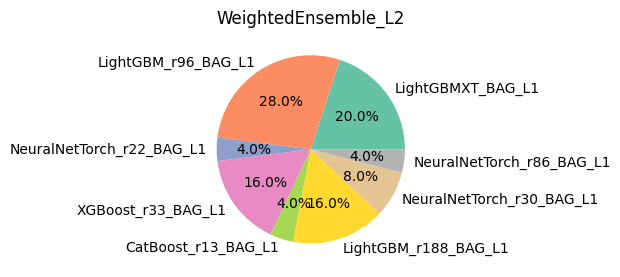

In [12]:
ensemble_weights = get_ensemble_weights(predictor)

for key, value in ensemble_weights.items():
    plt.figure(figsize=(6, 6))
    plt.pie(value.values(), labels=value.keys(), autopct="%1.1f%%", colors=sns.color_palette("Set2", len(value)))
    plt.title(key)
    plt.tight_layout()
    plt.show()

# Collecting and saving OOF files

In [13]:
def save_preds(preds, cv_score, name, type, is_ensemble):
    base_path = "oof_preds" if type == "oof" else "test_preds"
    base_path = "." if is_ensemble else base_path
    joblib.dump(preds, f"{base_path}/{name}_{type}_preds_{cv_score:.6f}.pkl")

def save_submission(test_preds, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub["prediction"] = test_preds
    sub.to_csv(f"sub_autogluon_{score:.6f}.csv", index=False)
    
os.makedirs("oof_preds", exist_ok=True)
os.makedirs("test_preds", exist_ok=True)

In [14]:
oof_preds = {}
test_preds = {}

overall_scores = {}

In [15]:
def pearsonr(y_true, y_pred):
    return pr(y_true, y_pred)[0]

In [16]:
best_model = predictor.model_best
_test_preds = predictor.predict_multi(test)
for model in predictor.model_names():
    model_oof_preds = predictor.predict_oof(model).values
    model_test_preds = _test_preds[model].values
    
    cv_score = pr(train[CFG.target], model_oof_preds)[0]
    if model != best_model:
        save_preds(model_oof_preds, cv_score, model, "oof", False)
        save_preds(model_test_preds, cv_score, model, "test", False)
    else:
        save_preds(model_oof_preds, cv_score, model, "oof", True)
        save_preds(model_test_preds, cv_score, model, "test", True)
        save_submission(model_test_preds, cv_score)
        
    oof_preds[model] = model_oof_preds
    test_preds[model] = model_test_preds

    overall_scores[model] = [pr(model_oof_preds, train[CFG.target])[0]]

# Visualizing the results

In [17]:
fold_scores = {}
split = KFold(n_splits=CFG.n_folds, shuffle=False).split(train, train[CFG.target])
for fold_idx, (train_index, val_index) in enumerate(split):
    for model in predictor.model_names():
        fold_score = pr(train.loc[val_index, CFG.target], oof_preds[model][val_index])[0]
        if model not in fold_scores:
            fold_scores[model] = []
        fold_scores[model].append(fold_score)

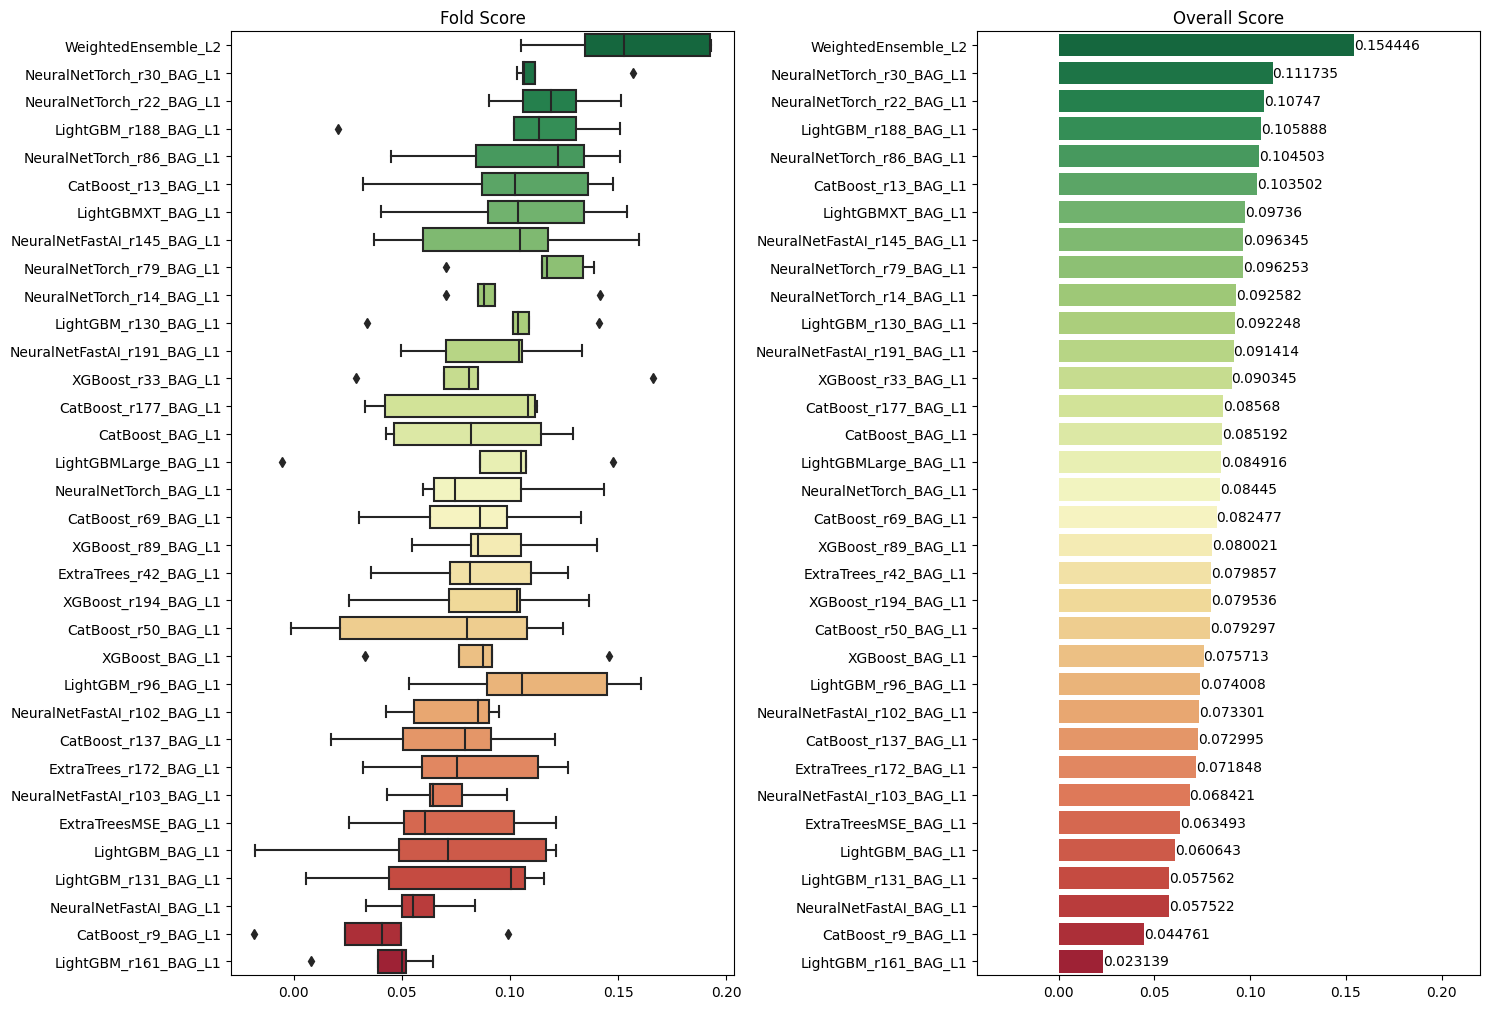

In [18]:
fold_scores = pd.DataFrame(fold_scores)
overall_scores = pd.DataFrame(overall_scores).transpose().sort_values(by=0, ascending=False)
order = overall_scores.index.tolist()

min_score = overall_scores.values.flatten().min()
max_score = overall_scores.values.flatten().max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, fold_scores.shape[1] * 0.3))

boxplot = sns.boxplot(data=fold_scores, order=order, ax=axs[0], orient="h", palette="RdYlGn_r")
axs[0].set_title(f"Fold Score")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=overall_scores.values.flatten(), y=overall_scores.index, ax=axs[1], palette="RdYlGn_r")
axs[1].set_title(f"Overall Score")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(overall_scores.values.flatten(), overall_scores.index)):
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()